C:\conda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow backend.


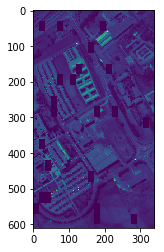

In [1]:
import os
from random import randint
from matplotlib import pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from utils import load_patches, combine_patches
from python_research.experiments.utils.datasets.hyperspectral_dataset import HyperspectralDataset
from python_research.experiments.utils.datasets.subset import BalancedSubset
from python_research.experiments.multiple_feature_learning.builders.keras_builders import build_3d_model, build_settings_for_dataset, build_1d_model
from python_research.preprocessing.grids.grid_extraction import extract_grids
%matplotlib inline

PATCHES_DIRECTORY = ""
DATASET_PATH = "C:\\Users\mmyller.KPLABS\Documents\datasets\pavia\PaviaU_corrected.npy"
DATASET_GT_PATH = "C:\\Users\mmyller.KPLABS\Documents\datasets\pavia\PaviaU_gt.npy"
OUTPUT_PATH = "grids_validation_3D\\artifact"
PATCH_SIZE = (17, 30)
PIXEL_NEIGHBOURHOOD = 7
TOTAL_NUMBER_OF_TRAIN_SAMPLES = 2700
CLASSES_COUNT = 9
PATIENCE = 15
EPOCHS = 200
BATCH_SIZE = 64
os.makedirs("grids_validation_3D", exist_ok=True)


# Load data if path to the folder with patches is specified
if PATCHES_DIRECTORY != "":
    train_data, test_data = load_patches(PATCHES_DIRECTORY, PIXEL_NEIGHBOURHOOD)
    dataset_image = test_data.x[:, :, randint(0, test_data.x.shape[-1])]
    train_data.normalize_labels()
    test_data.normalize_labels()
    bands_count = test_data.shape[-1]
    if PIXEL_NEIGHBOURHOOD == 1:
        train_data.expand_dims(axis=-1)
        test_data.expand_dims(axis=-1)
    val_data = BalancedSubset(train_data, 0.1)
# Extract grids from provided dataset if path was not specified
else:
    patches, test_set, dataset_image = extract_grids(DATASET_PATH, DATASET_GT_PATH, PATCH_SIZE, 
                                                     TOTAL_NUMBER_OF_TRAIN_SAMPLES)
    train_data, test_data = combine_patches(patches[0], patches[1], test_set[0], test_set[1], 
                                            PIXEL_NEIGHBOURHOOD)
    train_data.normalize_labels()
    test_data.normalize_labels()
    if PIXEL_NEIGHBOURHOOD == 1:
        train_data.expand_dims(axis=-1)
        test_data.expand_dims(axis=-1)
    val_data = BalancedSubset(train_data, 0.1)
# Show location of extracted grids
plt.imshow(dataset_image)
plt.show()


In [6]:

# Normalize data
max_ = train_data.max if train_data.max > val_data.max else val_data.max
min_ = train_data.min if train_data.min < val_data.min else val_data.min
train_data.normalize_min_max(min_=min_, max_=max_)
val_data.normalize_min_max(min_=min_, max_=max_)
test_data.normalize_min_max(min_=min_, max_=max_)

# Build model
if PIXEL_NEIGHBOURHOOD == 1:
    model = build_1d_model((test_data.shape[1:]), 200, 5, CLASSES_COUNT)
else:
    settings = build_settings_for_dataset((PIXEL_NEIGHBOURHOOD,
                                           PIXEL_NEIGHBOURHOOD))
    model = build_3d_model(settings, CLASSES_COUNT, test_data.shape[-1])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 4, 4, 200)         329800    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 200)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 200)         160200    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 9)           7209      
_________________________________________________________________
flatten_1 (Flatten)          (None, 9)                 0         
_________________________________________________________________
softmax_1 (Softmax)          (None, 9)                 0         
Total params: 497,209
Trainable params: 497,209
Non-trainable params: 0
_________________________________________________________________
None

In [8]:
# Callbacks
early = EarlyStopping(patience=PATIENCE)
checkpoint = ModelCheckpoint(OUTPUT_PATH + "_model", save_best_only=True)

model.fit(x=train_data.get_data, y=train_data.get_one_hot_labels(CLASSES_COUNT), batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=False,
          callbacks=[early, checkpoint], validation_data=[val_data.get_data, val_data.get_one_hot_labels(CLASSES_COUNT)])

best_model = load_model(OUTPUT_PATH + "_model")

# Evaluate test set score
accuracy = best_model.evaluate(x=test_data.get_data, y=test_data.get_one_hot_labels(CLASSES_COUNT))[1]
print("Test set accuracy: {}".format(accuracy))


   32/40042 [..............................] - ETA: 47s

  352/40042 [..............................] - ETA: 11s

  640/40042 [..............................] - ETA: 9s 

  992/40042 [..............................] - ETA: 8s

 1344/40042 [>.............................] - ETA: 7s

 1696/40042 [>.............................] - ETA: 7s

 2016/40042 [>.............................] - ETA: 7s

 2336/40042 [>.............................] - ETA: 7s

 2720/40042 [=>............................] - ETA: 6s

 3040/40042 [=>............................] - ETA: 6s

 3424/40042 [=>............................] - ETA: 6s

 3744/40042 [=>............................] - ETA: 6s

 4128/40042 [==>...........................] - ETA: 6s

 4448/40042 [==>...........................] - ETA: 6s

 4768/40042 [==>...........................] - ETA: 6s

 5120/40042 [==>...........................] - ETA: 6s

 5472/40042 [===>..........................] - ETA: 6s

 5856/40042 [===>..........................] - ETA: 5s

 6176/40042 [===>..........................] - ETA: 5s

 6560/40042 [===>..........................] - ETA: 5s

 6880/40042 [====>.........................] - ETA: 5s

 7200/40042 [====>.........................] - ETA: 5s

 7616/40042 [====>.........................] - ETA: 5s

 7936/40042 [====>.........................] - ETA: 5s

 8320/40042 [=====>........................] - ETA: 5s

 8640/40042 [=====>........................] - ETA: 5s

 9024/40042 [=====>........................] - ETA: 5s

 9344/40042 [======>.......................] - ETA: 5s

 9632/40042 [======>.......................] - ETA: 5s

10016/40042 [======>.......................] - ETA: 5s

10336/40042 [======>.......................] - ETA: 5s

10720/40042 [=======>......................] - ETA: 4s

11072/40042 [=======>......................] - ETA: 4s

11392/40042 [=======>......................] - ETA: 4s

11744/40042 [=======>......................] - ETA: 4s

12064/40042 [========>.....................] - ETA: 4s

12480/40042 [========>.....................] - ETA: 4s

12800/40042 [========>.....................] - ETA: 4s

13184/40042 [========>.....................] - ETA: 4s

13504/40042 [=========>....................] - ETA: 4s

13888/40042 [=========>....................] - ETA: 4s

14208/40042 [=========>....................] - ETA: 4s

14528/40042 [=========>....................] - ETA: 4s

14912/40042 [==========>...................] - ETA: 4s

15264/40042 [==========>...................] - ETA: 4s

15616/40042 [==========>...................] - ETA: 4s

15968/40042 [==========>...................] - ETA: 4s

16352/40042 [===========>..................] - ETA: 3s

16736/40042 [===========>..................] - ETA: 3s

17056/40042 [===========>..................] - ETA: 3s

17408/40042 [============>.................] - ETA: 3s

17760/40042 [============>.................] - ETA: 3s

18144/40042 [============>.................] - ETA: 3s

18464/40042 [============>.................] - ETA: 3s

18816/40042 [=============>................] - ETA: 3s

19200/40042 [=============>................] - ETA: 3s

19520/40042 [=============>................] - ETA: 3s

19904/40042 [=============>................] - ETA: 3s

20224/40042 [==============>...............] - ETA: 3s

20544/40042 [==============>...............] - ETA: 3s

20928/40042 [==============>...............] - ETA: 3s

21248/40042 [==============>...............] - ETA: 3s

21664/40042 [===============>..............] - ETA: 3s

21952/40042 [===============>..............] - ETA: 3s

22304/40042 [===============>..............] - ETA: 2s

22592/40042 [===============>..............] - ETA: 2s

22976/40042 [================>.............] - ETA: 2s

23296/40042 [================>.............] - ETA: 2s

23616/40042 [================>.............] - ETA: 2s

24000/40042 [================>.............] - ETA: 2s

24320/40042 [=================>............] - ETA: 2s

24704/40042 [=================>............] - ETA: 2s

25024/40042 [=================>............] - ETA: 2s

25440/40042 [==================>...........] - ETA: 2s

25760/40042 [==================>...........] - ETA: 2s

26080/40042 [==================>...........] - ETA: 2s

26464/40042 [==================>...........] - ETA: 2s

26784/40042 [===================>..........] - ETA: 2s

27168/40042 [===================>..........] - ETA: 2s

27488/40042 [===================>..........] - ETA: 2s

27776/40042 [===================>..........] - ETA: 2s

28160/40042 [====================>.........] - ETA: 1s

28512/40042 [====================>.........] - ETA: 1s

28896/40042 [====================>.........] - ETA: 1s

29216/40042 [====================>.........] - ETA: 1s

29600/40042 [=====================>........] - ETA: 1s

29920/40042 [=====================>........] - ETA: 1s

30240/40042 [=====================>........] - ETA: 1s

30560/40042 [=====================>........] - ETA: 1s

30912/40042 [======================>.......] - ETA: 1s

31296/40042 [======================>.......] - ETA: 1s

31616/40042 [======================>.......] - ETA: 1s

31968/40042 [======================>.......] - ETA: 1s

32320/40042 [=======================>......] - ETA: 1s

32704/40042 [=======================>......] - ETA: 1s

33024/40042 [=======================>......] - ETA: 1s

33344/40042 [=======================>......] - ETA: 1s

33728/40042 [========================>.....] - ETA: 1s

34080/40042 [========================>.....] - ETA: 0s

34464/40042 [========================>.....] - ETA: 0s

34784/40042 [=========================>....] - ETA: 0s

35168/40042 [=========================>....] - ETA: 0s

35488/40042 [=========================>....] - ETA: 0s

35808/40042 [=========================>....] - ETA: 0s

36192/40042 [==========================>...] - ETA: 0s

36512/40042 [==========================>...] - ETA: 0s

36896/40042 [==========================>...] - ETA: 0s

37248/40042 [==========================>...] - ETA: 0s

37632/40042 [===========================>..] - ETA: 0s

37952/40042 [===========================>..] - ETA: 0s

38272/40042 [===========================>..] - ETA: 0s

38656/40042 [===========================>..] - ETA: 0s

38976/40042 [============================>.] - ETA: 0s

39360/40042 [============================>.] - ETA: 0s

39680/40042 [============================>.] - ETA: 0s

40042/40042 [==============================] - 7s 166us/step


Test set accuracy: 0.7350282203715901
